In [15]:
import pandas as pd
df_init = pd.read_csv('C:/_WaferMLdata/df_joined.csv', low_memory=False)
df_init = df_init[:1000]

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# df_init

In [2]:
import numpy as np
df_all = df_init.set_index('WaferID')

# The prefix_sep='_' makes each class has a unique name separated by the delimiter. 
# The drop_first=True drops one column from the resulted dummy features. The purpose is to avoid multicollinearity. 
df_all = pd.get_dummies(df_all, prefix_sep='_', drop_first=True)

# If you want to impute your data either use a rolling average using .rolling() to replace missing value with the mean value of a rolling window. 
# If you want something more robust use module <b>missingpy</b> you can use MissForest for a randomforest based imputation
# You can't fill the X_test NAs with the X_test mean, because in real life you won't have the X_test mean when you're predicting a sample. 
# You should use the X_train mean because this is the only data you actually have in hand (in 99% of the scenarios)
df_all = df_all.astype(np.float64)
df_all = df_all.replace([np.inf, -np.inf], np.nan)
df_all = df_all.fillna(df_all.mean())
df_all = df_all.fillna(0)
print('# of NaNs in df_all:', df_all.isnull().values.sum())

# from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(df_all, test_size=0.5)

# of NaNs in df_all: 0


In [3]:
#−1.0 to −0.7 Strong negative correlation
#−0.7 to −0.4 Negative correlation
#−0.4 to −0.2 Weak negative correlation
#−0.2 to +0.2 There is no correlation
#+0.2 to +0.4 Weak positive correlation
#+0.4 to +0.7 Positive correlation
#+0.7 to +1.0 Strong Positive correlation
train_corr = df_all.corr()

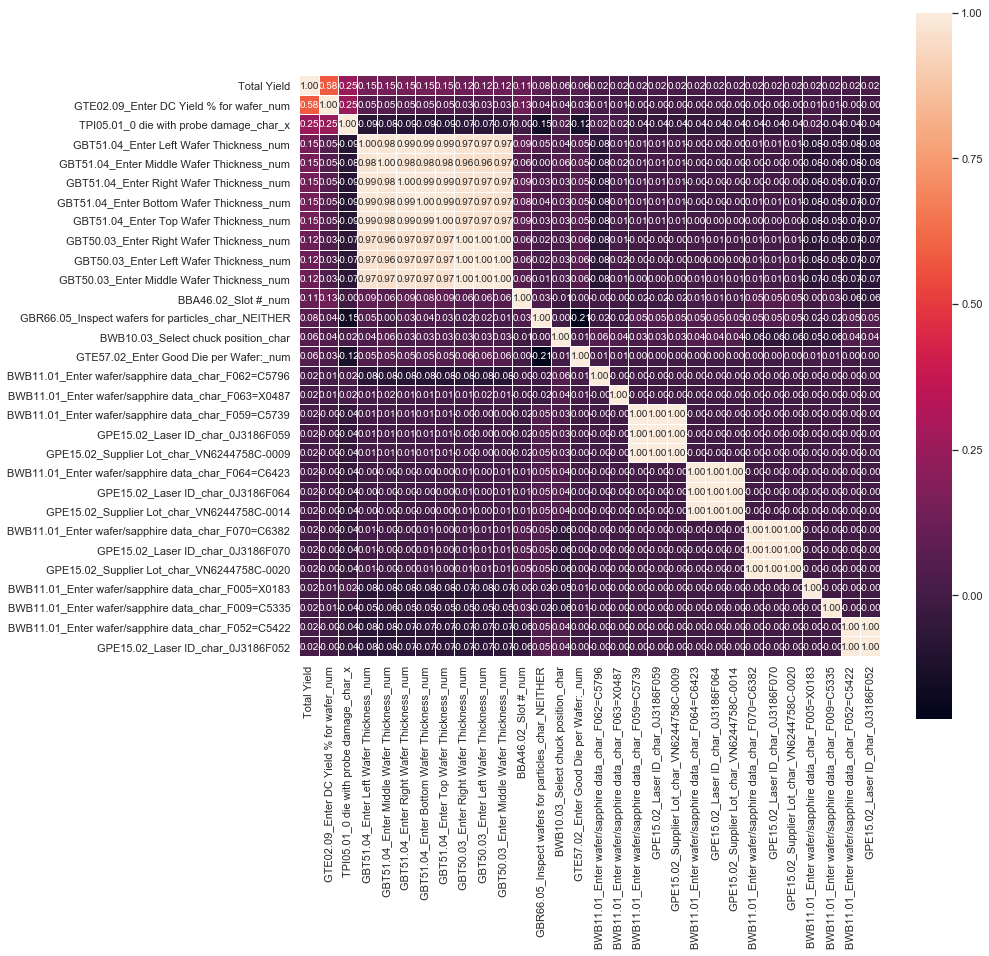

In [7]:
k = 30 #number of variables for heatmap
cols = train_corr.nlargest(k, 'Total Yield')['Total Yield'].index
cm = np.corrcoef(df_all[cols].values.T)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(13,13)) 
hm = sns.heatmap(cm, cbar=True, annot=True, linewidths=.01, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.set_size_inches(18.5, 10.5)
plt.show()

In [5]:
# todo pear down to ~2000 top variables

y = df_all["Total Yield"]
X = df_all[df_all.columns.tolist()[1:]]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)  # Don't cheat - fit only on training data # todo update this! 
X = scaler.transform(X)
# df_test_X = scaler.transform(df_test_X)  # apply same transformation to test data

In [8]:
from sklearn.model_selection import cross_val_score
import timeit
from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import tree

print('started')
models = []
# models.append(('LinearRegression', linear_model.LinearRegression())) # LinAlgError: SVD did not converge in Linear Least Squares
# models.append(('RANSACRegressor', linear_model.RANSACRegressor())) # more samples?
# models.append(('Perceptron', linear_model.Perceptron()))  # needs labels?

models.append(('SGDRegressor', linear_model.SGDRegressor(max_iter=10000, tol=1e-3)))
models.append(('SGDRegressor2', linear_model.SGDRegressor(penalty='elasticnet', alpha=0.01,
                                  l1_ratio=0.25, fit_intercept=True,
                                  tol=1e-4)))
models.append(('Ridge', linear_model.Ridge(alpha=.5)))
models.append(('Lasso', linear_model.Lasso(alpha=0.1)))
models.append(('LassoLars', linear_model.LassoLars(alpha=0.1)))

models.append(('TheilSenRegressor', linear_model.TheilSenRegressor()))
models.append(('HuberRegressor', linear_model.HuberRegressor()))
models.append(('SVR', svm.SVR(gamma='auto')))
models.append(('svr_rbf', svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)))
models.append(('svr_lin', svm.SVR(kernel='linear', C=100, gamma='auto')))
models.append(('svr_poly', svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)))

models.append(('GradientBoostingRegressor', ensemble.GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, loss='ls')))
models.append(('GradientBoostingRegressor2', ensemble.GradientBoostingRegressor(n_estimators=10)))
models.append(('RandomForestRegressor', ensemble.RandomForestRegressor(n_estimators=10)))
models.append(('RidgeCV', linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))))
models.append(('BayesianRidge', linear_model.BayesianRidge()))
models.append(('KNeighborsRegressor', neighbors.KNeighborsRegressor(5, weights='uniform')))
models.append(('DecisionTreeRegressor', tree.DecisionTreeRegressor(max_depth=1)))

# reg1 = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
# reg2 = linear_model.BayesianRidge()
# reg3 = ensemble.GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls')
# models.append(('VotingRegressor', ensemble.VotingRegressor(estimators=[('reg1', reg1), ('reg2', reg2), ('reg3', reg3)])))

results = []
names = []
for name, model in models:
    start = timeit.default_timer()
    result = cross_val_score(model, X, y,  cv=3) # https://scikit-learn.org/stable/modules/cross_validation.html
    print(name, '- learning time (mins): ', round((timeit.default_timer() - start) / 60.0, 1))
    print(name, "- Accuracy: %0.2f (+/- %0.2f)" % (result.mean(), result.std() * 2))
#     print(name, '- cross val accuracy:', result)
    
    names.append(name)
    results.append(result)

# for i in range(len(names)):
#     print(names[i], '- in sample error:', results[i].mean())

started
SGDRegressor - learning time (mins):  0.0
SGDRegressor - Accuracy: -202139574367758.16 (+/- 438473092741775.44)
SGDRegressor2 - learning time (mins):  0.0
SGDRegressor2 - Accuracy: -2104155.66 (+/- 5224907.99)
Ridge - learning time (mins):  0.0
Ridge - Accuracy: -0.83 (+/- 0.76)
Lasso - learning time (mins):  0.0
Lasso - Accuracy: -0.03 (+/- 0.06)
LassoLars - learning time (mins):  0.0
LassoLars - Accuracy: -0.03 (+/- 0.06)
TheilSenRegressor - learning time (mins):  0.0
TheilSenRegressor - Accuracy: -9467603043207318546581291008.00 (+/- 18149839908326217088336134144.00)
HuberRegressor - learning time (mins):  0.1
HuberRegressor - Accuracy: -0.18 (+/- 0.72)
SVR - learning time (mins):  0.0
SVR - Accuracy: -0.37 (+/- 0.86)
svr_rbf - learning time (mins):  0.0
svr_rbf - Accuracy: -0.38 (+/- 0.62)
svr_lin - learning time (mins):  0.1
svr_lin - Accuracy: -0.37 (+/- 0.46)
svr_poly - learning time (mins):  0.0
svr_poly - Accuracy: -0.32 (+/- 0.41)
GradientBoostingRegressor - learning 